In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:100% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:14pt;}
div.text_cell_render.rendered_html{font-size:14pt;}
div.text_cell_render ul li, code{font-size:22pt; line-height:14px;}
div.output {font-size:14pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:14pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:14pt;padding:5px;}
table.dataframe{font-size:14px;}
</style>
"""))

# <span style="color:red">ch8_트랜스포머(영화평감상분석)</span>
- 다중분류분석
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정   -이미 케라스에 학습 데이터가 들어있다

# 1. 패키지 import

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time  # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남

In [3]:
MY_WORDS = 20000  # imdb 데이터 안의 단어 수 - 늘리면 늘릴수록 좋을 수 있다.
MY_LENGTH = 200    # 독립변수 차원(영화평 단어수 80개로 맞출 예정)-영화평 평균길이 정도가 좋다. 많이 늘릴수록 0이 많이들어가서 학습이 잘 안될 수 있다.
MY_EMBED  = 32    # Embedding 결과 차원
MY_HIDDEN = 64    # LSTM의 uits 수

MY_EPOCH  = 15    # fit 반복학습 수 - 얼리스타핑으로 최적 횟수
MY_BATCH  = 200   # 배치사이즈(fit 할 대, 매번 가져오는 데이터 수)- 정확도와는 상관이 없고 속도에만 영향을 미친다.

# # 불용어 설정(빈도수가 높은 상위 1~?은 대부분 the,a,is...)
# SKIP_TOP = 30  문맥학습시 빼는게 좋다

# 3. 데이터 불러오기

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS,  # 1~MYWORDS이외는 2로 가져옴
                                                      #skip_top=SKIP_TOP   # 1~20까지를 2로 가져옴. 문맥학습시 빼는게 좋다
                                                     )

In [88]:
print('학습용 독립변수 모양 :',X_train.shape)
print('학습용 타겟변수 모양 :',y_train.shape)
print('학습용 독립변수 샘플 :',X_train[0][:80])
print('학습용 타겟변수 (0:부정/1:긍정) 샘플 :',y_train[0])
print('테스트용 독립변수 모양 :',X_test.shape)
print('테스트용 타겟변수 모양 :',y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [2, 2, 2, 2, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 36, 256, 2, 2, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 4536, 1111, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 1247, 2, 2, 2]
학습용 타겟변수 (0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [9]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [10]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :',y_train.sum())
print('테스트데이터의 긍정 갯수 :',y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [5]:
word_to_id = imdb.get_word_index()  # 단어(word):정수(id)word_index - 빈도가 높은 단어는 앞으로
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {}  # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_STOP값을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1,48)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [6]:
msg = "What a wonderful movieasdfg"
msg = msg.lower().split()
print(msg)
# 1:리뷰의 시작을 알리는 숫자 2:MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoding된 내용(data)_SKIP_TOP처리 안 할 경우 :', data)

print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movieasdfg']
원 후기 내용 : ['what', 'a', 'wonderful', 'movieasdfg']
encoding된 내용(data)_SKIP_TOP처리 안 할 경우 : [1, 51, 6, 389, 2]
data 추정 : ??? what a wonderful ???


In [25]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [7]:
def decoding(review_nums):
    decoded = []   # 숫자를 단어로 해석한 내용 append
    # print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3,'???')
        decoded.append(word)
    print(' '.join(decoded))

In [8]:
print(X_train[0])
print(decoding(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
??? this film was just brilliant casting locatio

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [9]:
def show_length():
    print('첫 10개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이: {len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
print('pad_sequence 작업전')
show_length()        

pad_sequence 작업전
첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [10]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [11]:
# 영화평 길이 평균
# mean([len(x) for x in X_train])  # 리스트에는 mean()적용X
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평이 길이를 동일하게(MY_LENGTH 만큼)

In [12]:
X_train = pad_sequences(X_train,
                        maxlen=MY_LENGTH,
                        truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                        #truncating='pre',
                        #padding='post',
                        padding='pre',  # 길 경우, 뒷부분을 자르고 짧은 경우 앞에 zero를 붙임
                       )
X_test = pad_sequences(X_test,
                        maxlen=MY_LENGTH,
                        truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                        #truncating='pre',
                        #padding='post',
                        padding='pre',  # 길 경우, 뒷부분을 자르고 짧은 경우 앞에 zero를 붙임
                       )
print('pad_sequence 작업후')
show_length()  

pad_sequence 작업후
첫 10개 영화평 길이
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


In [13]:
X_train[0]

array([    1,    14,    22,    16,    43,   530,   973,  1622,  1385,
          65,   458,  4468,    66,  3941,     4,   173,    36,   256,
           5,    25,   100,    43,   838,   112,    50,   670,     2,
           9,    35,   480,   284,     5,   150,     4,   172,   112,
         167,     2,   336,   385,    39,     4,   172,  4536,  1111,
          17,   546,    38,    13,   447,     4,   192,    50,    16,
           6,   147,  2025,    19,    14,    22,     4,  1920,  4613,
         469,     4,    22,    71,    87,    12,    16,    43,   530,
          38,    76,    15,    13,  1247,     4,    22,    17,   515,
          17,    12,    16,   626,    18, 19193,     5,    62,   386,
          12,     8,   316,     8,   106,     5,     4,  2223,  5244,
          16,   480,    66,  3785,    33,     4,   130,    12,    16,
          38,   619,     5,    25,   124,    51,    36,   135,    48,
          25,  1415,    33,     6,    22,    12,   215,    28,    77,
          52,     5,

# 8. 최종 데이터 shape 확인

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 200), (25000,), (25000, 200), (25000,))

In [37]:
decoding(X_train[0])

??? ??? film ??? just brilliant casting ??? ??? story direction ??? really ??? ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same ??? ??? ??? myself so ??? loved ??? fact there ??? ??? real ??? ??? ??? film ??? ??? ??? throughout ??? film were great ??? ??? just brilliant so much ??? ??? ??? ??? film ???


# 9. LSTM 모델 생성 및 구현

In [97]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,       # 1000
                    output_dim=MY_EMBED,      # 32
                    input_length=MY_LENGTH))  # 80
model.add(LSTM(units=MY_HIDDEN,               #64
               dropout=0.4,  # 0.1~0.5 각 스텝마다 LSTM셀로 들어가는 연결. 30%를 0으로
               recurrent_dropout=0.3,  # 0.1~0.3 이전 LSTM에서 다음 LSTM셀로 가는 연결. 20%를 0으로
               # input_shape=(MY_LENGTH, MY_EMBED), # 80*32 (생략해도 들어온다)
               # kernel_initializer='he_normal',     # 입력 가중치 초기화
               # recurrent_initializer='orthogonal', # 순환 가중치 초기화
              ))    
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           640000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 664,897
Trainable params: 664,897
Non-trainable params: 0
_________________________________________________________________


# 9. Transformers 인코딩부분 모델구현

In [20]:
from tensorflow import range
from tensorflow.keras.layers import Input, Dropout, MultiHeadAttention, add
from tensorflow.keras.layers import BatchNormalization, GlobalAvgPool1D, Dense
from tensorflow.keras.models import Model, Sequential

# 입력층, 임베딩층
INPUTS = Input(shape=(MY_LENGTH, ))
INPUT_EMBEDDING = Embedding(input_dim=MY_WORDS,
                            output_dim=MY_EMBED)(INPUTS)
# Positional encoding
POSITIONS = range(start=0,
                 limit=MY_LENGTH)
POS_ENCODING = Embedding(input_dim=MY_WORDS,
                        output_dim=MY_EMBED)(POSITIONS)
POS_ENC_OUTPUT = POS_ENCODING + INPUT_EMBEDDING
# Multi-Head Attention
ATTENTION_OUTPUT = MultiHeadAttention(num_heads=3,
                                     key_dim=MY_EMBED)(POS_ENC_OUTPUT,POS_ENC_OUTPUT) # self attention이라서 2개 넣어준다.
X = add([POS_ENC_OUTPUT, ATTENTION_OUTPUT])
X = BatchNormalization()(X) # batch 정규화

# Feed Forward Network 선형을 비선형으로 만드는 작업
FFN = Sequential([
    Dense(MY_HIDDEN, activation='relu'),
    Dense(MY_EMBED, activation='relu'),
])(X)
X = add([FFN, X])
X = BatchNormalization()(X)
# 출력된 데이터를 하나의 벡터로 하여 Dense에 보냄
X = GlobalAvgPool1D()(X)
X = Dropout(0.1)(X)
X = Dense(units=MY_HIDDEN,  activation='relu')(X)
X = Dropout(0.1)(X)
OUTPUTS = Dense(units=2,   # 부정그룹/긍정그룹(다중그룹방식)
               activation='softmax')(X)
model = Model(inputs = INPUTS,
             outputs = OUTPUTS)

# 10. 학습환경 설정 및 학습하기

In [21]:
model.compile(# loss='binary_crossentropy', # 이중분류(로지스틱회기분석)
              loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']
             )
start = time()  # 1970.01.01~이 시점까지 초
earlyStopping = EarlyStopping(patience=5)
hist = model.fit(X_train, y_train,
                 epochs=MY_EPOCH,
                 batch_size=MY_BATCH,
                 validation_split=0.2,
                 verbose=1,
                 callbacks=[earlyStopping])
end = time()    # 1970.01.01~이 시점까지 초
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/15
100/100 [==============================] - 43s 419ms/step - loss: 0.4648 - acc: 0.7718 - val_loss: 0.5524 - val_acc: 0.8570
Epoch 2/15
100/100 [==============================] - 46s 466ms/step - loss: 0.2082 - acc: 0.9197 - val_loss: 0.4796 - val_acc: 0.7976
Epoch 3/15
100/100 [==============================] - 46s 458ms/step - loss: 0.1220 - acc: 0.9566 - val_loss: 0.4556 - val_acc: 0.7684
Epoch 4/15
100/100 [==============================] - 47s 467ms/step - loss: 0.0764 - acc: 0.9730 - val_loss: 0.4613 - val_acc: 0.8014
Epoch 5/15
100/100 [==============================] - 47s 474ms/step - loss: 0.0536 - acc: 0.9812 - val_loss: 0.4220 - val_acc: 0.8558
Epoch 6/15
100/100 [==============================] - 45s 453ms/step - loss: 0.0509 - acc: 0.9819 - val_loss: 0.6349 - val_acc: 0.8414
Epoch 7/15
100/100 [==============================] - 48s 480ms/step - loss: 0.0370 - acc: 0.9866 - val_loss: 0.9192 - val_acc: 0.8300
Epoch 8/15
100/100 [==============================] - 4

# 11. 모델평가

In [86]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

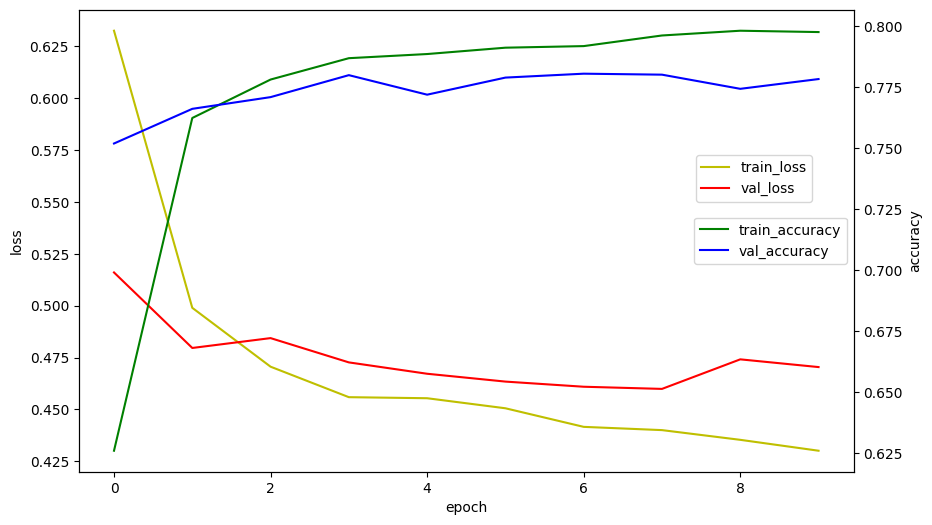

In [45]:
# 모델 평가
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'],'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'],'r', label='val_loss')
acc_ax = loss_ax.twinx()  # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [46]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 5s 6ms/step - loss: 0.4696 - acc: 0.7764
test의 데이터 정확도 : 0.7763599753379822


In [47]:
# 모델 저장
model.save('imdb_v2.10_skiptop20length80.h5')

In [52]:
# 혼동행렬(교차표, 평가성능지표)
# y_test  # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int)  # 예측값
y_hat

782/782 [==============================] - 5s 6ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [51]:
pd.crosstab(y_test, y_hat.reshape(-1))

col_0,False,True
row_0,,
0,9999,2501
1,3090,9410


In [53]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [54]:
# 실제값과 예측값(2차원)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[9999, 2501],
       [3090, 9410]], dtype=int64)

In [63]:
# 실제값과 예측값의 차원이 1차원
ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab['0_확률'] = [ctab.loc[0,0]/25000 *100 , ctab.loc[1,0]/25000*100]
ctab['1_확률'] = [ctab.loc[0,1]/25000 *100 , ctab.loc[1,1]/25000*100]
ctab

예측값,0,1,0_확률,1_확률
실제값,,,,
0,9999,2501,39.996,10.004
1,3090,9410,12.360,37.640


In [67]:
# accuracy, precision, recall, f1_score
print('acc:',acc)
print('precision :',precision_score(y_test, y_hat))
print('recall :', recall_score(y_test, y_hat))
print('f1_score :', f1_score(y_test, y_hat))

acc: 0.7763599753379822
precision : 0.7900260263621862
recall : 0.7528
f1_score : 0.7709639097128345


# 12. 모델 사용하기

In [75]:
# 긍정문
import re
review = """This film is truly outstanding in every way. 
The casting is exceptional—each actor fits their role perfectly and delivers a memorable performance. 
The story, direction, cinematography, and music all come together beautifully,
creating an experience that is both captivating and deeply enjoyable. 
Every element feels thoughtfully crafted, making the movie a pleasure to watch from beginning to end. 
I genuinely loved everything about it. ^_^ -.- :)""".lower()

review = re.sub('[^a-zA-Z0-9\s]',' ', review)
review = review.split()
print(review)
encoded = [1]+[word_to_id.get(r, -1)+3 for r in review]
encoded = [2 if (e<=30)|(e>10000) else e for e in encoded]   # skip_top 사용시
print(encoded, len(encoded))

['this', 'film', 'is', 'truly', 'outstanding', 'in', 'every', 'way', 'the', 'casting', 'is', 'exceptional', 'each', 'actor', 'fits', 'their', 'role', 'perfectly', 'and', 'delivers', 'a', 'memorable', 'performance', 'the', 'story', 'direction', 'cinematography', 'and', 'music', 'all', 'come', 'together', 'beautifully', 'creating', 'an', 'experience', 'that', 'is', 'both', 'captivating', 'and', 'deeply', 'enjoyable', 'every', 'element', 'feels', 'thoughtfully', 'crafted', 'making', 'the', 'movie', 'a', 'pleasure', 'to', 'watch', 'from', 'beginning', 'to', 'end', 'i', 'genuinely', 'loved', 'everything', 'about', 'it']
[2, 2, 22, 2, 371, 2, 2, 175, 96, 2, 973, 2, 2, 257, 284, 2, 68, 217, 950, 2, 2, 2, 906, 239, 2, 65, 458, 627, 2, 228, 32, 216, 295, 2, 2, 35, 585, 2, 2, 199, 2, 2, 2, 737, 175, 2, 764, 2, 2, 231, 2, 2, 2, 2, 2, 106, 39, 454, 2, 130, 2, 2, 447, 285, 44, 2] 66


In [76]:
input_data = pad_sequences([encoded],
                        maxlen=MY_LENGTH,
                        truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                        #truncating='pre',
                        #padding='post',
                        padding='pre',  # 길 경우, 뒷부분을 자르고 짧은 경우 앞에 zero를 붙임
                       )
input_data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   2,   2,  22,   2, 371,   2,   2, 175,  96,   2, 973,   2,
          2, 257, 284,   2,  68, 217, 950,   2,   2,   2, 906, 239,   2,
         65, 458, 627,   2, 228,  32, 216, 295,   2,   2,  35, 585,   2,
          2, 199,   2,   2,   2, 737, 175,   2, 764,   2,   2, 231,   2,
          2,   2,   2,   2, 106,  39, 454,   2, 130,   2,   2, 447, 285,
         44,   2]])

In [78]:
(model.predict(input_data).argmax(axis=1)

1/1 [==============================] - 0s 24ms/step


array([[1]], dtype=int8)

In [82]:
# 부정문
review ="""This movie is an absolute disaster from start to finish. 
The story is confusing, poorly written, and completely lacking in direction. ^.^
The acting is painfully stiff, as if the cast had no idea what their characters were supposed to feel. 
The dialogue sounds unnatural and forced, making every scene difficult to watch.
The pacing drags endlessly, yet somehow still feels rushed in important moments. 
Even the visuals and music, which could have saved it, are bland and forgettable.
By the time the credits rolled, I regretted wasting my time. 
This film fails in every possible way and offers nothing worthwhile."""
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.lower().split()
encoded = [1]+[word_to_id.get(r, -1)+3 for r in review]
encoded = [e if (e>=30)&(e<=10000) else 2 for e in encoded]   # skip_top 사용시
print(encoded, len(encoded))

[2, 2, 20, 2, 35, 2, 2, 39, 380, 2, 2, 2, 65, 2, 2, 862, 398, 2, 340, 2, 2, 458, 2, 116, 2, 2, 2, 2, 48, 2, 177, 69, 57, 326, 51, 68, 105, 71, 424, 2, 235, 2, 414, 934, 2, 2, 918, 231, 175, 136, 878, 2, 106, 2, 2, 2, 2, 246, 820, 131, 764, 2, 2, 674, 388, 60, 2, 2, 2, 228, 63, 100, 28, 2, 2, 26, 2, 2, 2, 34, 2, 58, 2, 898, 2, 2, 2, 2, 61, 58, 2, 22, 996, 2, 175, 614, 96, 2, 2, 164, 2] 101


In [83]:
input_data = pad_sequences([encoded],
                        maxlen=MY_LENGTH,
                        truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                        #truncating='pre',
                        #padding='post',
                        padding='pre',  # 길 경우, 뒷부분을 자르고 짧은 경우 앞에 zero를 붙임
                       )
(model.predict(input_data) > 0.5).astype('int8')

1/1 [==============================] - 0s 22ms/step


array([[0]], dtype=int8)